# How to Build User Interfaces For AI Applications Using Streamlit And LangChain

## What We Will Build in This Tutorial

Rough notes: 
- We will build a football chatbot that will answer questions about International Football matches played since 1872
- The dataset we use comes from this Kaggle dataset that contains data on more than 40k matches, their results, teams, goal scores and other details
- You can see the demo of the app from this link and from the following GIF.
- The tutorial will serve as a blueprint for building user interfaces for any application that requires chatbot interfaces

## Prerequisite Concepts Refresher

### Streamlit

### Retrieval Augmented Generation

### LangChain

### Graph databases and Neo4j

## Understanding the App Requirements and The Data

##  Building a Graph RAG Chatbot in LangChain

### 1. Set up the environment

Let's start by creating a new Conda environment with Python 3.9 and activate it:

```bash
$ conda create -n football_chatbot python=3.9 -y
$ conda activate football_chatbot
```

We will need to install the following libraries:


```bash
$ pip install streamlit langchain langchain-openai langchain_community neo4j
```


Now, let's create our working directory and populate its structure:


```bash
$ mkdir football_chatbot; cd football_chatbot
$ mkdir .streamlit
$ touch {.streamlit/secrets.toml,app.py}
```


We will write our application inside `app.py` while `secrets.toml` inside `.streamlit` directory will serve as our credentials file. Open it and paste the following three secrets:


```yaml
NEO4J_URI = "neo4j+s://eed9dd8f.databases.neo4j.io"
NEO4J_USER = "neo4j"
NEO4J_PASSWORD = "ivbSF02UWzHeHuzBIePyOH5cQ4LdyRxLeNbWvdpPA4k"
```

These credentials give you access to the Aura DB instance that stores the football database. If you wish to create your own instance with the same data, refer to our [tutorial on Neo4j](https://www.datacamp.com/tutorial/neo4j-tutorial) that covers that exact step.

### 2. Import libraries and load the secrets

Now, let's work on the `app.py` file. At the top, import the necessary modules, packages and load the secrets using `st.secrets`:

```python
import streamlit as st
from langchain.chains import GraphCypherQAChain
from langchain_community.graphs import Neo4jGraph
from langchain_openai import ChatOpenAI
```

```python
# Load secrets
neo4j_uri = st.secrets["NEO4J_URI"]
neo4j_user = st.secrets["NEO4J_USER"]
neo4j_password = st.secrets["NEO4J_PASSWORD"]
```

Here is what each class does:
- `Neo4jGraph`: A shorthand class to connect to existing Neo4j databases and query them with Cypher.
- `GraphCypherQAChain`: an all-encompassing class to perform graph RAG on graph databases. By passing our graph loaded with `Neo4jGraph`, we can generate Cypher queries using natural language using this class. 
- `ChatOpenAI`: Gives access to the Chat Completions API of OpenAI. 

### 3. Add authentication

To prevent malicious usage and high costs, we should add an authentication that asks user's OpenAI API token. This can be achieved by adding a password form to the left sidebar using the `st.sidebar` element:

```python
# Set the app title
st.title("Football Memoirs - an AI for Hardcore Football Fans")

# Sidebar for API key input
with st.sidebar:
    openai_api_key = st.text_input("Enter your OpenAI API Key", type="password")
    st.warning("Please enter your OpenAI API key to use the chatbot.")
```

As soon as the user loads our app, they will be presented with the input field and nothing else will be shown (except app title) until they provide their key. 

### 4. Connect to Neo4j database and initialize a QA chain

After retrieving the user's OpenAI API key, we can initialize our resources: the Neo4j graph and the QA chain class:

```python
# Initialize connections and models
@st.cache_resource(show_spinner=False)
def init_resources(api_key):
    graph = Neo4jGraph(
        url=neo4j_uri,
        username=neo4j_user,
        password=neo4j_password,
        enhanced_schema=True,
    )
    graph.refresh_schema()

    chain = GraphCypherQAChain.from_llm(
        ChatOpenAI(api_key=api_key, model="gpt-4o"),
        graph=graph,
        verbose=True,
        show_intermediate_steps=True,
        allow_dangerous_requests=True,
    )
    return graph, chain
```

`init_resources()` function accepts the API key as an argument and establishes a connection with the graph database. Then, it refreshes graph schema (structure) so that the LLM can have up-to-date information about the database structure when formulating Cypher queries. Finally, it initializes the GraphCypherQAChain with the graph and OpenAI model, returning both the graph and chain objects for further use in the application.

It's worth noting the use of the `st.cache_resource()` decorator. This decorator caches the graph and chain instances, which improves performance. We don't need to create new instances every time a user loads the app, so caching them is an efficient approach.

Let's run the initializer with an API key check:

```python
# Initialize resources only if API key is provided
if openai_api_key:
    with st.spinner("Initializing resources..."):
        graph, chain = init_resources(openai_api_key)
        st.success("Resources initialized successfully!", icon="🚀")
```

### 4. Add message history to Streamlit

As soon as the resources are available, we need to enable message history by using Streamlit's session state. We also want to display an initial AI message informing the user what the bot does. 

To do so, we create a new `messages` key in `st.session_state` and set its value to a list with a single element. The element is a dictionary with two keys:
- `role`: To whom the message belongs
- `content`: The message content

```python
# Initialize message history
if "messages" not in st.session_state:
    st.session_state.messages = [
        {
            "role": "assistant",
            "content": "Hello! Ask me anything about International Football from 1872 to (the almost) present day!",
        }
    ]
```

```python
# Display chat history
for message in st.session_state.messages:
    with st.chat_message(message["role"]):
        st.markdown(message["content"])
```

### 5. Display chat components

```python
def query_graph(query):
    try:
        result = chain.invoke({"query": query})["result"]
        return result
    except Exception as e:
        st.error(f"An error occurred: {str(e)}")
        return "I'm sorry, I encountered an error while processing your request."
```

```python
# Accept user input
if prompt := st.chat_input("Your question..."):
    st.session_state.messages.append({"role": "user", "content": prompt})
    with st.chat_message("user"):
        st.markdown(prompt)

    # Generate answer if API key is provided
    if openai_api_key:
        with st.spinner("Thinking..."):
            response = query_graph(prompt)

        with st.chat_message("assistant"):
            st.markdown(response)

        st.session_state.messages.append({"role": "assistant", "content": response})
    else:
        st.error("Please enter your OpenAI API key in the sidebar to use the chatbot.")
```

### 6. Optimize and organize the code

```bash
$ cd football_chatbot
$ rm -rf .
$ mkdir .streamlit
$ touch {.streamlit/secrets.toml,.gitignore,app.py,chat_utils.py,graph_utils.py,README.MD,requirements.txt}
```

```python
# graph_utils.py
import streamlit as st
from langchain.chains import GraphCypherQAChain
from langchain_community.graphs import Neo4jGraph
from langchain_openai import ChatOpenAI


@st.cache_resource(show_spinner=False)
def init_resources(api_key):
    graph = Neo4jGraph(
        url=st.secrets["NEO4J_URI"],
        username=st.secrets["NEO4J_USER"],
        password=st.secrets["NEO4J_PASSWORD"],
        enhanced_schema=True,
    )
    graph.refresh_schema()

    chain = GraphCypherQAChain.from_llm(
        ChatOpenAI(api_key=api_key, model="gpt-4o"),
        graph=graph,
        verbose=True,
        show_intermediate_steps=True,
        allow_dangerous_requests=True,
    )
    return graph, chain


def query_graph(chain, query):
    result = chain.invoke({"query": query})["result"]
    return result
```

```python
# chat_utils.py
import streamlit as st


def initialize_chat_history():
    if "messages" not in st.session_state:
        st.session_state.messages = [
            {
                "role": "assistant",
                "content": "Hello! Ask me anything about International Football from 1872 to (the almost) present day!",
            }
        ]

def display_chat_history():
    for message in st.session_state.messages:
        with st.chat_message(message["role"]):
            st.markdown(message["content"])
```

```python
# chat_utils.py
def handle_user_input(openai_api_key, query_graph_func, chain):
    if prompt := st.chat_input("Your question..."):
        st.session_state.messages.append({"role": "user", "content": prompt})
        with st.chat_message("user"):
            st.markdown(prompt)

        if openai_api_key:
            with st.spinner("Thinking..."):
                try:
                    response = query_graph_func(chain=chain, query=prompt)
                except Exception as e:
                    st.error(f"An error occurred: {str(e)}")
                    response = "I'm sorry, I encountered an error while processing your request."

            with st.chat_message("assistant"):
                st.markdown(response)

            st.session_state.messages.append({"role": "assistant", "content": response})
        else:
            st.error(
                "Please enter your OpenAI API key in the sidebar to use the chatbot."
            )
```

```python
import streamlit as st
from graph_utils import init_resources, query_graph
from chat_utils import initialize_chat_history, display_chat_history, handle_user_input

st.title("Football Memoirs - an AI for Hardcore Football Fans")

# Sidebar for API key input
with st.sidebar:
    openai_api_key = st.text_input("Enter your OpenAI API Key", type="password")
    st.warning("Please enter your OpenAI API key to use the chatbot.")
```

```python
# Initialize resources only if API key is provided
if openai_api_key:
    with st.spinner("Initializing resources..."):
        graph, chain = init_resources(openai_api_key)
        st.success("Resources initialized successfully!", icon="🚀")

    # Initialize and display chat history
    initialize_chat_history()
    display_chat_history()

    # Handle user input
    handle_user_input(
        openai_api_key=openai_api_key, query_graph_func=query_graph, chain=chain
    )
```

### 7. Deploy the app to Streamlit Cloud

```.gitignore
*.toml
__pycache__/
```

```markdown
# Football Memoirs - AI for Hardcore Football Fans

This Streamlit app uses a Neo4j graph database and OpenAI's GPT-4o model to answer questions about international football history from 1872 to the present day.

## Setup

1. Clone this repository
2. Install dependencies: `pip install -r requirements.txt`
3. Set up your `.streamlit/secrets.toml` file with the following keys:
   - NEO4J_URI
   - NEO4J_USER
   - NEO4J_PASSWORD
4. Run the app: `streamlit run app.py`

## Deployment

To deploy this app on Streamlit Cloud:

1. Push your code to a GitHub repository
2. Connect your GitHub account to Streamlit Cloud
3. Create a new app in Streamlit Cloud and select your repository
4. Add your secrets in the Streamlit Cloud dashboard under the "Secrets" section
5. Deploy your app
```

```bash
$ git init
$ git add .
$ git commit -m "Initial commit"
$ git remote add origin https://github.com/Username/repository.git
$ git push --set-upstream origin main
```

[Streamlit Cloud](share.streamlit.io)

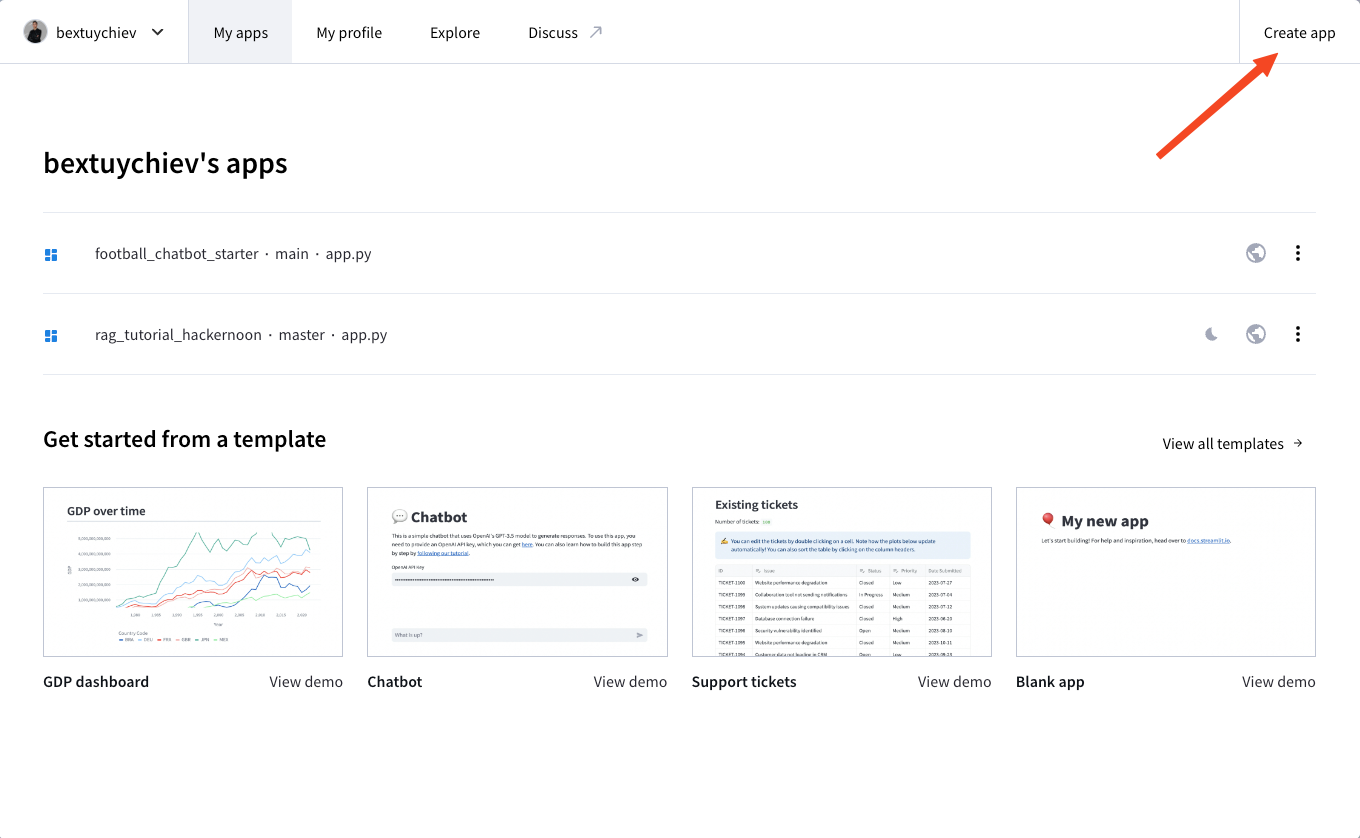

## Conclusion